# Peer-graded Assignment: Capstone Project - The Battle of Neighborhoods (Week 1)

## Exploring the restaurants of Toronto

Important the different libraries we will need

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

!pip install lxml

!pip install requests
import requests

from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt  

!pip install beautifulsoup4

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


### Data preparation

Scrap the data about Toronto neighborhood from Wikipedia

In [2]:
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
df1 = df[0]
df1.head(5)

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
df1 = df1[df1["Borough"] != "Not assigned"]

Add coordinates

In [4]:
df_coordinates = pd.read_csv("http://cocl.us/Geospatial_data")
df_final = df1.merge(df_coordinates)
df_final.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Use Foursquare

In [5]:
CLIENT_ID = 'R0I5FDP03JA1NS0AJSYISIAI0JURADPGEESDATISZU2Q24T0' # your Foursquare ID
CLIENT_SECRET = 'NZ03PRZXM1EEOALDGI0PJTACOG4ZNYGTSWCVXQPADBNUREYY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: R0I5FDP03JA1NS0AJSYISIAI0JURADPGEESDATISZU2Q24T0
CLIENT_SECRET:NZ03PRZXM1EEOALDGI0PJTACOG4ZNYGTSWCVXQPADBNUREYY


In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,  CLIENT_SECRET,  VERSION,  lat,  lng,  radius,  LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],  v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [7]:
LIMIT = 100
toronto_venues = getNearbyVenues(names=df_final['Neighborhood'],
                                   latitudes=df_final['Latitude'],
                                   longitudes=df_final['Longitude']
                                  )
toronto_venues.groupby('Neighborhood').count()
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot.insert(0, "neighborhood", toronto_venues["Neighborhood"], True)
toronto_grouped = toronto_onehot.groupby(['neighborhood']).mean().reset_index()
num_top_venues = 25

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Ri

Obtain a list of restaurants venues

In [8]:
Toronto_restaurants_venues = toronto_venues[toronto_venues["Venue Category"].str.contains("Restaurant")].reset_index(drop=True)
Toronto_restaurants_venues.index = np.arange(1, len(Toronto_restaurants_venues)+1 )
Toronto_restaurants_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
2,Parkwoods,43.753259,-79.329656,A&W,43.760643,-79.326865,Fast Food Restaurant
3,Parkwoods,43.753259,-79.329656,Spicy Chicken House,43.760639,-79.325671,Chinese Restaurant
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
5,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
6,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
7,"Regent Park, Harbourfront",43.654260,-79.360636,Souk Tabule,43.653756,-79.354390,Mediterranean Restaurant
8,"Regent Park, Harbourfront",43.654260,-79.360636,Mangia and Bevi Resto-Bar,43.652250,-79.366355,Italian Restaurant
9,"Regent Park, Harbourfront",43.654260,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
10,"Regent Park, Harbourfront",43.654260,-79.360636,Sukhothai,43.658444,-79.365681,Thai Restaurant


In [9]:
print('{} restaurants were returned by Foursquare.'.format(Toronto_restaurants_venues.shape[0]))

1206 restaurants were returned by Foursquare.


In [10]:
Restaurants_types = Toronto_restaurants_venues.groupby(['Venue Category']).count().reset_index()
Restaurants_types = Restaurants_types.sort_values(by=['Venue'], ascending = False)
Restaurants_types = Restaurants_types[['Venue Category', 'Venue']]
Restaurants_types.set_index('Venue Category', inplace=True)
Restaurants_types

,Venue
Venue Category,
Restaurant,143
Italian Restaurant,110
Japanese Restaurant,91
Sushi Restaurant,81
Fast Food Restaurant,65
Thai Restaurant,56
Chinese Restaurant,52
Vegetarian / Vegan Restaurant,46
Indian Restaurant,45


In [11]:
Restaurants_types.count()

Venue    61
dtype: int64

There are according to our list 61 types of restaurants. However, this list can be improved as some of the venues categories are redundant. For instance, "Japanese restaurant" and "Sushi restaurant" should be merged as sushi is a Japanese dish. To make the process easier, I will group the restaurants per continent. I will however create a group of other restaurants for restaurants that are not dedicated to the cooking of a specific county or region such as vegetarian restaurants comfort foods restaurants. 

In [12]:
Europe = ["Italian Restaurant", "Greek Restaurant", "French Restaurant", "Mediterranean Restaurant", "Portuguese Restaurant", "Eastern European Restaurant", "Tapas Restaurant", "Modern European Restaurant", "German Restaurant", "Belgian Restaurant"]
Asia = ["Japanese Restaurant", "Sushi Restaurant", "Thai Restaurant", "Chinese Restaurant","Indian Restaurant", "Vietnamese Restaurant", "Korean Restaurant", "Ramen Restaurant", "Asian Restaurant", "Cantonese Restaurant", "Filipino Restaurant", "Tibetan Restaurant", "Afghan Restaurant", "Pakistani Restaurant", "Indonesian Restaurant", "Indian Chinese Restaurant", "Malay Restaurant", "Taiwanese Restaurant", "Sri Lankan Restaurant", "Hong Kong Restaurant", "Shanghai Restaurant", "North Indian Restaurant", "Dim Sum Restaurant", "Hakka Restaurant", "Dumpling Restaurant", "Udon Restaurant", "Hotpot Restaurant" ]
Africa = ["Ethiopian Restaurant", "African Restaurant", "Moroccan Restaurant"]
America = ["American Restaurant", "Mexican Restaurant", "Caribbean Restaurant", "Latin American Restaurant", "New American Restaurant", "Brazilian Restaurant", "South American Restaurant", "Empanada Restaurant", "Hawaiian Restaurant", "Southern / Soul Food Restaurant" ]
Middle_East = ["Middle Eastern Restaurant", "Falafel Restaurant", "Turkish Restaurant", "Jewish Restaurant", "Persian Restaurant", "Syrian Restaurant" ]
Other = ["Restaurant", "Fast Food Restaurant", "Vegetarian / Vegan Restaurant", "Seafood Restaurant", "Comfort Food Restaurant", "Gluten-free Restaurant","Theme Restaurant"   ]

In [13]:
Regions = {"Continents": ["Europe", "Asia", "Africa", "America", "Middle_East", "Other"], "Venue Category": [Europe, Asia, Africa, America, Middle_East, Other]}
Regions_df = pd.DataFrame({ key:pd.Series(value) for key, value in Regions.items() })
Regions_df = Regions_df.explode('Venue Category')
Regions_df

,Continents,Venue Category
0,Europe,Italian Restaurant
0,Europe,Greek Restaurant
0,Europe,French Restaurant
0,Europe,Mediterranean Restaurant
0,Europe,Portuguese Restaurant
0,Europe,Eastern European Restaurant
0,Europe,Tapas Restaurant
0,Europe,Modern European Restaurant
0,Europe,German Restaurant
0,Europe,Belgian Restaurant


In [14]:
Regions_categories = Toronto_restaurants_venues.merge(Regions_df, on=["Venue Category"], how='left')
Main_Regions = Regions_categories.groupby(['Continents']).count().reset_index()
Main_Regions = Main_Regions[['Continents', 'Venue']]
Main_Regions = Main_Regions.set_index('Continents')
Main_Regions

,Venue
Continents,
Africa,8
America,135
Asia,465
Europe,226
Middle_East,58
Other,305


In [15]:
Main_Regions = Main_Regions.sort_values(by=['Venue'], ascending = False)
Main_Regions

,Venue
Continents,
Asia,465
Other,305
Europe,226
America,135
Middle_East,58
Africa,8


<function matplotlib.pyplot.show(*args, **kw)>

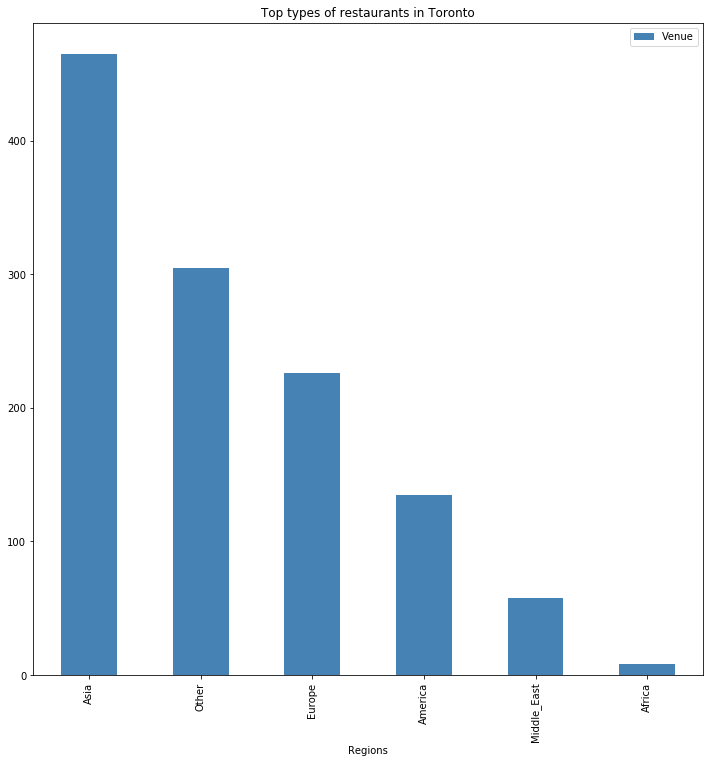

In [16]:
Main_Regions.plot(kind='bar', figsize=(12, 12), color='steelblue')
plt.xlabel('Regions')
plt.title('Top types of restaurants in Toronto')
plt.show

The majority of the restaurants in Toronto are Asian restaurants. Then, we have non specified restaurants and fast-foods. Although Italian restaurants are the most widespread type of restaurants in Toronto, European restaurants are only the third group of restaurants present in Toronto.

In [17]:
Restaurants_per_neighborhood = Toronto_restaurants_venues.groupby(['Neighborhood']).count().reset_index()
Restaurants_per_neighborhood_sorted = Restaurants_per_neighborhood.sort_values(by=['Venue'], ascending = False)
Restaurants_per_neighborhood_sorted = Restaurants_per_neighborhood_sorted[['Neighborhood', 'Venue']]
Restaurants_per_neighborhood_sorted.set_index('Neighborhood', inplace=True)
Restaurants_per_neighborhood_sorted.head(10)

,Venue
Neighborhood,
Willowdale,40
Davisville,37
"The Danforth West, Riverdale",34
Christie,34
"Little Portugal, Trinity",32
"The Annex, North Midtown, Yorkville",29
East Toronto,28
Studio District,27
"Garden District, Ryerson",26


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb3803fd908>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb3803fdf98>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb3803fd5f8>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb38038a668>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb38038a9b0>],
 'means': []}

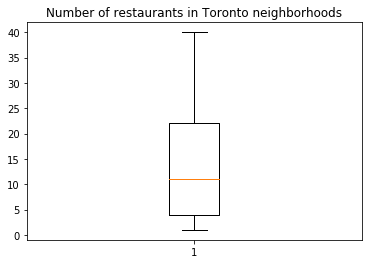

In [42]:
fig1, ax1 = plt.subplots()
ax1.set_title('Number of restaurants in Toronto neighborhoods')
ax1.boxplot(Restaurants_per_neighborhood_sorted["Venue"])

In [19]:
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude)
print(longitude)

43.6534817
-79.3839347


In [20]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for venue, lng, lat in zip(Toronto_restaurants_venues['Venue'], Toronto_restaurants_venues['Venue Longitude'], Toronto_restaurants_venues['Venue Latitude']):
    label = ' {}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  


map_toronto

In [21]:
Regions_categories.groupby('Neighborhood').count()
Toronto_restaurants_onehot = pd.get_dummies(Regions_categories[['Continents']], prefix="", prefix_sep="")
Toronto_restaurants_onehot.insert(0, "neighborhood", Regions_categories["Neighborhood"], True)
Toronto_restaurants_onehot.head()

,neighborhood,Africa,America,Asia,Europe,Middle_East,Other
0,Parkwoods,0,1,0,0,0,0
1,Parkwoods,0,0,0,0,0,1
2,Parkwoods,0,0,1,0,0,0
3,Victoria Village,0,0,0,1,0,0
4,Victoria Village,0,0,0,1,0,0


In [22]:
Toronto_restaurants_grouped = Toronto_restaurants_onehot.groupby(['neighborhood']).mean().reset_index()

In [23]:
num_top_venues = 15

for hood in Toronto_restaurants_grouped['neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_restaurants_grouped[Toronto_restaurants_grouped['neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
         venue  freq
0         Asia  0.68
1      America  0.18
2        Other  0.09
3       Europe  0.05
4       Africa  0.00
5  Middle_East  0.00


----Alderwood, Long Branch----
         venue  freq
0       Africa   1.0
1      America   0.0
2         Asia   0.0
3       Europe   0.0
4  Middle_East   0.0
5        Other   0.0


----Bathurst Manor, Wilson Heights, Downsview North----
         venue  freq
0         Asia  0.25
1       Europe  0.25
2  Middle_East  0.25
3        Other  0.25
4       Africa  0.00
5      America  0.00


----Bayview Village----
         venue  freq
0         Asia  0.75
1        Other  0.25
2       Africa  0.00
3      America  0.00
4       Europe  0.00
5  Middle_East  0.00


----Bedford Park, Lawrence Manor East----
         venue  freq
0       Europe  0.42
1         Asia  0.25
2        Other  0.25
3      America  0.08
4       Africa  0.00
5  Middle_East  0.00


----Berczy Park----
         venue  freq
0        Other  0.42
1         Asia  0.26
2

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = Toronto_restaurants_grouped['neighborhood']

for ind in np.arange(Toronto_restaurants_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_restaurants_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Asia,America,Other,Europe,Middle_East
1,"Alderwood, Long Branch",Africa,Other,Middle_East,Europe,Asia
2,"Bathurst Manor, Wilson Heights, Downsview North",Other,Middle_East,Europe,Asia,America
3,Bayview Village,Asia,Other,Middle_East,Europe,America
4,"Bedford Park, Lawrence Manor East",Europe,Other,Asia,America,Middle_East


In [26]:
toronto_grouped_clustering = Toronto_restaurants_grouped.drop('neighborhood', 1)

In [27]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,20) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering) 
    kmeanModel.fit(toronto_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / toronto_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / toronto_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

In [28]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 0.3573867550576341
2 : 0.30232038654520715
3 : 0.25863428250893034
4 : 0.230932148986901
5 : 0.21773641093101864
6 : 0.2011803515855499
7 : 0.18232262791871584
8 : 0.17379797039350198
9 : 0.15956491053060315
10 : 0.15403814185478812
11 : 0.14480242494453374
12 : 0.13868119127378037
13 : 0.13389777239414194
14 : 0.12624855864817056
15 : 0.12235251803630667
16 : 0.11613696750345025
17 : 0.10885800948574137
18 : 0.10711279430870056
19 : 0.10141294583465109


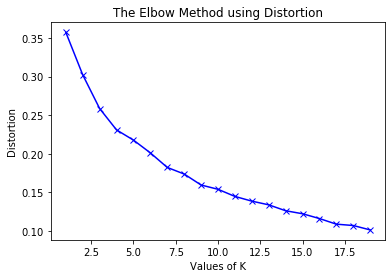

In [29]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [30]:
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

1 : 16.18103574682473
2 : 11.647884857888869
3 : 8.43350756966393
4 : 6.525725922288256
5 : 5.324422087381048
6 : 4.575222729426739
7 : 3.901186385027119
8 : 3.4508927330281214
9 : 3.0628445240413473
10 : 2.784594017288362
11 : 2.509792662256164
12 : 2.2646332348628047
13 : 2.11197088312763
14 : 1.9011231481916462
15 : 1.7612506778557089
16 : 1.564158236318476
17 : 1.4206878071372473
18 : 1.3617155127048228
19 : 1.2359540932159976


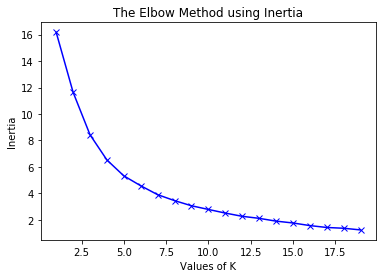

In [31]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [32]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [33]:
for k in K:
    clusterer = KMeans(n_clusters=k +1, random_state=10)
    cluster_labels = clusterer.fit_predict(toronto_grouped_clustering)
    sample_silhouette_values = silhouette_samples(toronto_grouped_clustering, cluster_labels, metric='euclidean')
    silhouette_avg = silhouette_score(toronto_grouped_clustering, cluster_labels)
    print(k+1)
    print(silhouette_avg)

2
0.25138818435524907
3
0.3074172963559822
4
0.315859493864673
5
0.3257360694345811
6
0.27232486487521496
7
0.2895138022127444
8
0.3198905434391549
9
0.3067249359358438
10
0.32010299025479944
11
0.33590708324857244
12
0.3256916762004245
13
0.33370618282677256
14
0.3409448162203143
15
0.32533971514762955
16
0.32415246817519205
17
0.337850061877195
18
0.3352573965478989
19
0.35301623079458416
20
0.3490195721419141


In [34]:
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 2, 1, 2, 2, 2, 2, 2, 1], dtype=int32)

In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_final

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index("neighborhood"), on="Neighborhood",how = "right")

toronto_merged.head() 

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,Other,Asia,America,Middle_East,Europe
1,M4A,North York,Victoria Village,43.725882,-79.315572,3,Europe,Other,Middle_East,Asia,America
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Asia,Europe,Other,Middle_East,America
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,4,Other,Asia,Europe,Middle_East,America
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Asia,Other,Europe,Middle_East,America


In [36]:
toronto_merged.dropna()
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color = rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
93,Etobicoke,0,Africa,Other,Middle_East,Europe,Asia


In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Downtown Toronto,1,Asia,Other,Europe,Middle_East,America
14,East York,1,Asia,Other,Middle_East,Europe,America
22,Scarborough,1,Asia,Other,Middle_East,Europe,America
25,Downtown Toronto,1,Asia,America,Other,Europe,Africa
26,Scarborough,1,Asia,Other,Europe,America,Middle_East
29,East York,1,Asia,Middle_East,Other,Europe,America
38,Scarborough,1,Asia,Other,Middle_East,Europe,America
39,North York,1,Asia,Other,Middle_East,Europe,America
47,East Toronto,1,Asia,Other,Europe,Middle_East,America
49,North York,1,Asia,Europe,Other,Middle_East,America


In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,North York,2,Other,Asia,America,Middle_East,Europe
2,Downtown Toronto,2,Asia,Europe,Other,Middle_East,America
7,North York,2,Asia,Other,America,Europe,Middle_East
13,North York,2,Asia,Other,America,Europe,Middle_East
9,Downtown Toronto,2,Asia,Other,Europe,America,Middle_East
16,York,2,Middle_East,Europe,Asia,Other,America
19,East Toronto,2,Asia,Other,Europe,America,Middle_East
20,Downtown Toronto,2,Other,Asia,Europe,America,Middle_East
21,York,2,Other,Middle_East,Asia,America,Europe
23,East York,2,Asia,Other,Europe,America,Middle_East


In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,North York,3,Europe,Other,Middle_East,Asia,America
12,Scarborough,3,Europe,Other,Middle_East,Asia,America
50,North York,3,Europe,Other,Middle_East,Asia,America
101,Etobicoke,3,Europe,Other,Middle_East,Asia,America


In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,North York,4,Other,Asia,Europe,Middle_East,America
6,Scarborough,4,Other,Asia,America,Africa,Middle_East
8,East York,4,Other,Middle_East,Europe,Asia,America
10,North York,4,Other,Asia,Europe,America,Middle_East
11,Etobicoke,4,Other,America,Middle_East,Europe,Asia
15,Downtown Toronto,4,Other,Europe,Asia,America,Middle_East
18,Scarborough,4,Other,Europe,Middle_East,Asia,America
32,Scarborough,4,Other,Asia,Middle_East,Europe,America
44,Scarborough,4,Other,America,Middle_East,Europe,Asia
56,York,4,Other,Europe,Middle_East,Asia,America
